# Computer Vision Project - Determining a Persons Age by Photo

In this project, we were asked by a supermarket to create a model to determine a persons age from a photo. The shop is equipped with cameras that are triggered when a person is purchasing alcohol, so the task is to verify their age to see if they are of legal age. Evaluating the model using the mean absolute error metric to evaluate the performance of the model.

## Initialization

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
data= pd.read_csv("/datasets/faces/labels.csv")

## EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
duplicated_sum = data.duplicated().sum()
print(f"There are {duplicated_sum} duplicated values in the data.")

There are 0 duplicated values in the data.


In [5]:
average_age = data['real_age'].mean()
print(f"The Average Age of Customers is {int(average_age)} years old.")

The Average Age of Customers is 31 years old.


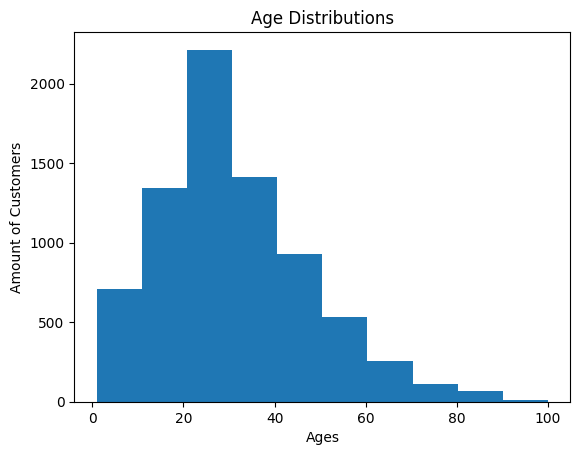

In [6]:
data['real_age'].plot(
kind= 'hist')
plt.title("Age Distributions")
plt.xlabel("Ages")
plt.ylabel("Amount of Customers")
plt.show()

Dataset Size: (7591, 2)


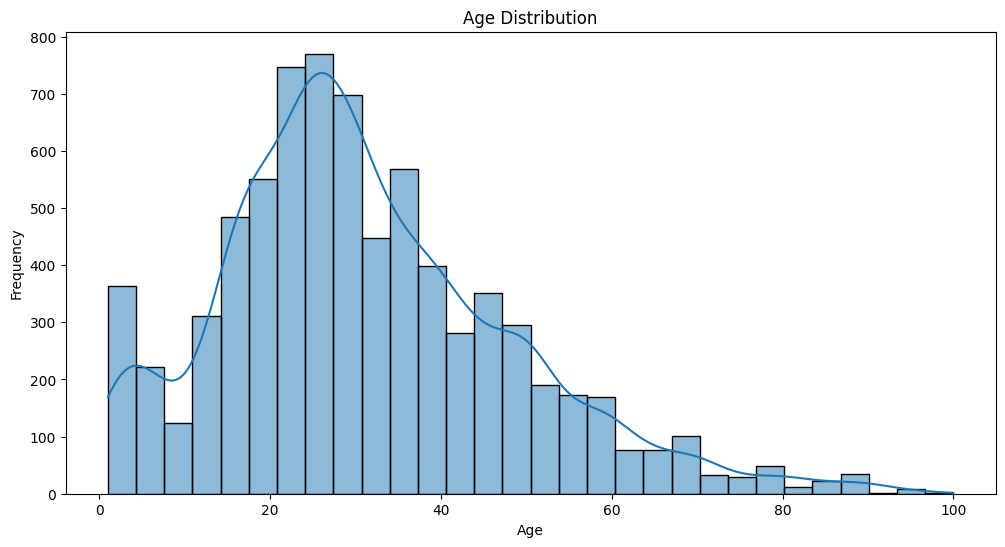

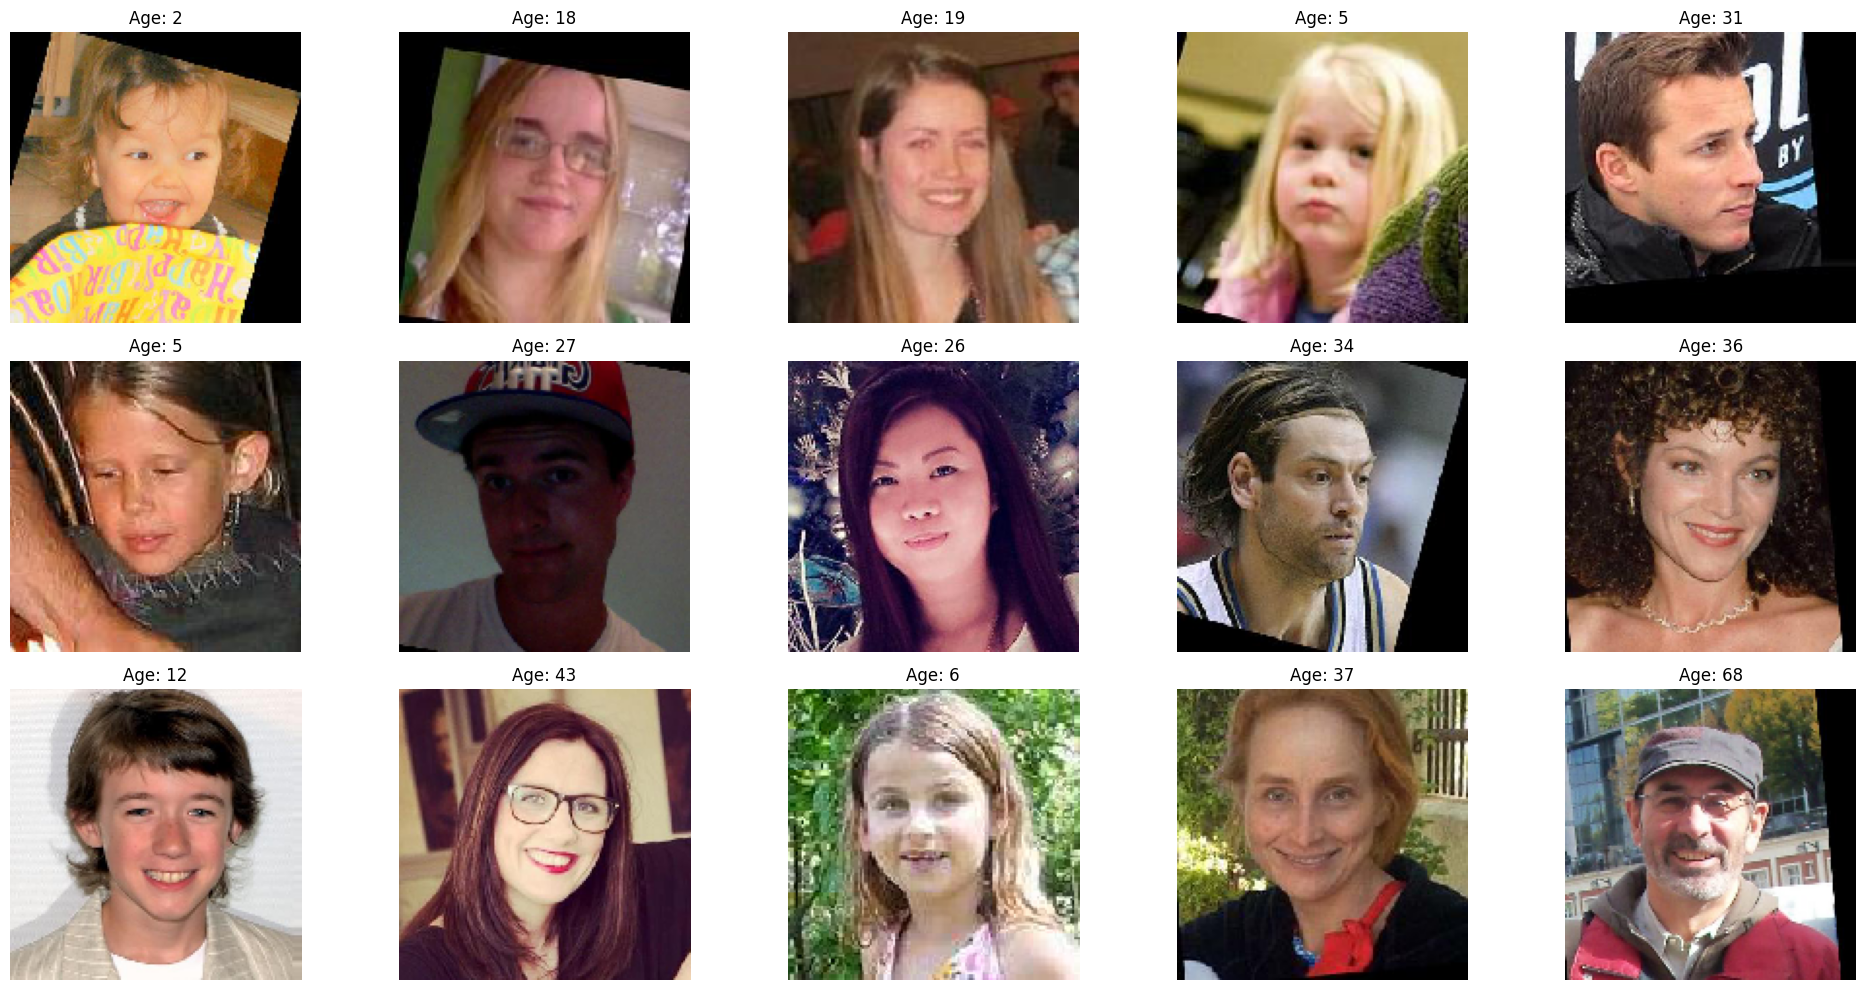

In [7]:
print("Dataset Size:", data.shape)

plt.figure(figsize=(12,6))
sns.histplot(data['real_age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

def plot_sample_images(df, directory, num_samples=15):
    plt.figure(figsize=(20, 10))
    sample_df = df.sample(num_samples)
    for i, (index, row) in enumerate(sample_df.iterrows()):
        file_name = row['file_name']
        age = row['real_age']
        img = load_img(directory + file_name, target_size=(150, 150))
        plt.subplot(3, 5, i+1)
        plt.imshow(img)
        plt.title(f'Age: {age}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(data, '/datasets/faces/final_files/')

### Findings

After analyzing the data, you can see that the average age of the people in the dataframe is 31 years. old. Also, by looking at the images that were in the output, you can see that there are more adults than kids in the data. Another thing that we must take into consideration is the rotation of the images as it can have an influence on our model

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [8]:
def load_train(path):
    """
    It loads the train part of dataset from path
    """
    # Load the labels CSV file as a pandas DataFrame
    labels = pd.read_csv(path + 'labels.csv')
    
    # Create an ImageDataGenerator with validation split
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    # Using the ImageDataGenerator, create a generator for the training subset
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,                # The DataFrame containing the file names and labels
        directory=f"{path}final_files/", # The directory containing the image files
        x_col='file_name',               # Column in the DataFrame that contains the image file names
        y_col='real_age',                # Column in the DataFrame that contains the labels
        target_size=(224, 224),          # Resize the images to 224x224 pixels
        batch_size=32,                   # Number of images to read at once
        class_mode='raw',                # Use 'raw' since it's a regression problem
        subset='training',               # Specify subset as training
        seed=12345                       # Random seed for reproducibility
    )

    return train_gen_flow


In [10]:
def load_test(path):
    """
    It loads the test part of dataset from path
    """
    # Load the labels CSV file as a pandas DataFrame
    labels = pd.read_csv(path + 'labels.csv')
    
    # Create an ImageDataGenerator with validation split
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    # Using the ImageDataGenerator, create a generator for the validation subset
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,                # The DataFrame containing the file names and labels
        directory=f"{path}final_files/", # The directory containing the image files
                x_col='file_name',               # Column in the DataFrame that contains the image file names
        y_col='real_age',                # Column in the DataFrame that contains the labels
        target_size=(224, 224),          # Resize the images to 224x224 pixels
        batch_size=32,                   # Number of images to read at once
        class_mode='raw',                # Use 'raw' since it's a regression problem
        subset='validation',             # Specify subset as validation
        seed=12345                       # Random seed for reproducibility
    )

    return test_gen_flow

In [12]:
def create_model(input_shape):
    """
    It defines the model
    """
   
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [13]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [14]:
# Define initialization imports
init_str = """
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
"""

# Import inspect module to get the source code of functions
import inspect

# Write initial imports and function definitions to the script
with open('run_model_on_gpu.py', 'w') as f:
    f.write(init_str)
    f.write('\n\n')
    
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

# Define the main script execution part
main_str = """
if __name__ == "__main__":
    # Paths to the datasets
    train_data_path = "/datasets/faces"  # Update this
    test_data_path = "/datasets/faces"   # Update this
    
    # Load the training and test data
    train_data = load_train(train_data_path)
    test_data = load_test(test_data_path)
    
    # Define the input shape
    input_shape = (224, 224, 3)
    
    # Create the model
    model = create_model(input_shape)
    
    # Train the model
    model = train_model(model, train_data, test_data, epochs=20)
    
    # Save the model
    model.save("age_prediction_model.h5")
"""

# Append the main script execution to the script file
with open('run_model_on_gpu.py', 'a') as f:
    f.write(main_str)

### Output

Epoch 1/20  
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921  
Epoch 2/20  
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035  
Epoch 3/20  
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454  
Epoch 4/20   
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481  
Epoch 5/20  
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192  
Epoch 6/20  
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332  
Epoch 7/20  
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359  
Epoch 8/20  
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239  
Epoch 9/20  
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529  
Epoch 10/20  
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629  
Epoch 11/20  
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866  
Epoch 12/20  
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591  
Epoch 13/20  
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467  
Epoch 14/20  
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401  
Epoch 15/20  
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841  
Epoch 16/20  
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304  
Epoch 17/20  
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419  
Epoch 18/20  
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226  
Epoch 19/20  
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908  
Epoch 20/20  
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512  

## Conclusions

The project successfully built a convolutional neural network model to estimate a person's age from their photo using computer vision techniques. The model achieved a training MAE of 3.1785 and a validation MAE of 7.6512. The lowest validation MAE was 6.9908, which is an acceptable performance considering the complexity of the task. There are methods we csn use to improve the quality of the model for data augmentation like: rotate, flip, scale images, just to name a few. Also, we can use filters, we can normalize pixel values, in the image preprocessing. 